# Кузнецов Михаил Пи19-4


# Оптимальное решение в условиях неопределенности



### Импортирование нужных библиотек

In [12]:
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, LpMaximize
import pandas as pd
import random
import matplotlib.pyplot as plt

#### Метод для ввода пользователем матрицы весовых коэффициентов и названия стратегий с клавиатуры и вектора вероятности

In [2]:
def enterCoef(n, m):
    game_matrix = [ [0]*m for i in range(n) ]
    
    names_of_strategies_a = [0] * n
    names_of_strategies_nature = [0] * m
    # ввод стратегий игрока А
    for i in range(n):
        name = input(f"Введите название  {i+1} стратегии игрока А: ")
        if (name.isdigit() == False) and (len(name) != 0):
            names_of_strategies_a[i] = name
        else:
            print("Плохой ввод названия стратегии")
            raise ValueError
     # ввод имен стратегий состояний природы
    for i in range(m):
        name = input(f"Введите название  {i+1} состояния природы: ")
        if (name.isdigit() == False) and (len(name) != 0):
            names_of_strategies_nature[i] = name
        else:
            print("Плохой ввод названия состояния")
            raise ValueError
    print("Заполните матрицу весовых коэффициентов")        
    for i in range(n):
        for j in range(m):
            num = int(input(f"Введите элемент строки {i+1} столбца {j+1}: "))
            if num > 0:
                game_matrix[i][j] = num
            else:
                raise ValueError

         
    return (np.array(game_matrix), names_of_strategies_a, names_of_strategies_nature)

#### Метод для ввода пользователем названия стратегий с клавиатуры и случайная генерация матрицы весовых коэффициентов

In [3]:
def randomCoef(n,m):
    game_matrix = [ [0]*m for i in range(n) ]
    
    names_of_strategies_a = [0] * n
    names_of_strategies_nature = [0] * m
    # ввод стратегий игрока А
    for i in range(n):
        name = input(f"Введите название  {i+1} стратегии игрока А: ")
        if (name.isdigit() == False) and (len(name) != 0):
            names_of_strategies_a[i] = name
        else:
            print("Плохой ввод названия стратегии")
            raise ValueError
     # ввод имен стратегий состояний природы
    for i in range(m):
        name = input(f"Введите название  {i+1} состояния природы: ")
        if (name.isdigit() == False) and (len(name) != 0):
            names_of_strategies_nature[i] = name
        else:
            print("Плохой ввод названия состояния")
            raise ValueError
            
    game_matrix = np.random.randint(1, 500, size = (n,m))
    return (np.array(game_matrix), names_of_strategies_a, names_of_strategies_nature)

#### Метод для считывания из csv

In [4]:
def readFromScv(path1 = "data/dataA.csv"):
    main_matrix = pd.read_csv(path1)
    names_of_strategies_a = list(main_matrix['Names_a'])
    main_matrix.drop('Names_a', inplace=True, axis=1)
    game_matrix = None
    names_of_strategies_nature = list(main_matrix.columns)
    if sum(main_matrix.isnull().sum()):
        print("Содержатся пропуски!")
        raise ValueError
    else:
        if sum(main_matrix.dtypes == object) > 0:
            print("Содержится строка в файле!")
            raise ValueError
        elif (main_matrix <= 0).any().any() == True:
            print("Содержится отрицательное или нулевое значение!")
            raise ValueError
        else:
            game_matrix = main_matrix.to_numpy()
    
                
    return (game_matrix, names_of_strategies_a, names_of_strategies_nature)

In [68]:
class UndefinedGame:
    
    def __init__(self, game_matrix, names_strategies_A, names_strategies_nature):
        self.game_matrix = game_matrix
        self.names_strategies_A = names_strategies_A
        self.names_names_strategies_nature = names_strategies_nature
        
        self.pessimizm_strategies = None
        self.cost_pessimizm = None
        
        self.optimizm_strategies = None
        self.cost_optimizm = None
        
        #Вальд
        self.Vald_strategies = None
        self.cost_Vald = None
        
        #Гурвиц
        self.linear_Gurviz = None
        
        #Сэвидж
        self.Savage_strategies = None
        self.Savage_total = None
        
        
    
    def simplex_method(self, matrix, F_type, C_type_f):
        model = LpProblem("Game", F_type)
        variables = []

        for i in range(matrix.shape[0]):
            v = LpVariable(f'v{i+1}', lowBound=0)
            variables.append(v)
        
        variables_np = np.array(variables)

        del variables
        
        function = (variables_np).sum()
        model += function
        
        all_constraints = C_type_f((matrix * variables_np).sum(axis=1), 1)
        for c in all_constraints:
            model += c        
        model.solve()
        optimal = np.array(list(map(lambda p: p.value(), model.variables())))
        
        return optimal / optimal.sum(),  1 / optimal.sum()
    

    def pessimizm(self):
        pessimism_criterion = self.game_matrix.min(axis=1)
        pessimism_criterion_opt_v = pessimism_criterion.min()
        pessimism_criterion_opt = np.argwhere(pessimism_criterion == pessimism_criterion_opt_v).reshape(-1)
        pessimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {self.names_strategies_A[x]}', pessimism_criterion_opt))
        
        self.pessimizm_strategies = pessimism_criterion_opt_strategies
        self.cost_pessimizm = pessimism_criterion_opt_v
    
    def optimizm(self):
        optimism_criterion = self.game_matrix.max(axis=1)
        optimism_criterion_opt_v = optimism_criterion.max()
        optimism_criterion_opt = np.argwhere(optimism_criterion == optimism_criterion_opt_v).reshape(-1)
        optimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {self.names_strategies_A[x]}', optimism_criterion_opt))
        
        self.optimizm_strategies = optimism_criterion_opt_strategies
        self.cost_optimizm = optimism_criterion_opt_v
    
    def Vald(self):
        wald_criterion = self.game_matrix.min(axis=1)
        wald_criterion_opt_v = wald_criterion.max()
        wald_criterion_opt = np.argwhere(wald_criterion == wald_criterion_opt_v).reshape(-1)
        wald_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {self.names_strategies_A[x]}', wald_criterion_opt))
    
        self.Vald_strategies = wald_criterion_opt_strategies
        self.cost_Vald = wald_criterion_opt_v
        
    def Savage(self):
        R = self.game_matrix.max(axis=0) - self.game_matrix # матрица рисков
        savage_criterion = R.max(axis=1)
        savage_criterion_opt_v = savage_criterion.min()
        savage_criterion_opt = np.argwhere(savage_criterion == savage_criterion_opt_v).reshape(-1)
        savage_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {self.names_strategies_A[x]}', savage_criterion_opt))
        
        
        self.Savage_strategies = savage_criterion_opt_strategies
        self.Savage_total = savage_criterion[savage_criterion > savage_criterion_opt_v].min() - savage_criterion_opt_v
    
    def Gurviz(self):
        A = list([f'A{i + 1}' for i in range(self.game_matrix.shape[0])])

        conv = pd.DataFrame(columns= A + ['max'], index=np.arange(0, 1 + 0.1, 0.1))
        for alpha in conv.index:
            conv.loc[alpha, A] = alpha * self.game_matrix.max(axis=1) + (1 - alpha) * self.game_matrix.min(axis=1)
        conv.index.name = "alpha"
        conv['max'] = conv[A].max(axis=1)
        
        self.linear_Gurviz = conv
    
    def show_Gurviz_diagramm(self):
        A = list([f'A{i + 1}' for i in range(self.game_matrix.shape[0])])
        diagram = self.linear_Gurviz[A].plot.bar(figsize=(10,10), color=["green", "blue", "orange", "black"])
        plt.title("Гистограмма (диаграмма) максимумов линейной свертки по критерию Гурвица",fontsize=25)
        diagram.set_xlabel("Величина склонности к риску")
        diagram.set_ylabel("Цена игры")
        plt.plot(10 * self.linear_Gurviz.index, self.linear_Gurviz['max'], color="red", label='max')
        diagram.legend()
        plt.show()
        
    
    def __str__(self):
        return "Результаты решения\n" + "".join([
        "Optimal of А by pessimizm: {}\n".format(self.pessimizm_strategies),
        "Cost optimal by pessimizm: {}\n".format(self.cost_pessimizm),
        "Optimal of А by optimizm: {}\n".format(self.optimizm_strategies),
        "Cost optimal by optimizm: {}\n".format(self.cost_optimizm),
        "Optimal of А by Vald: {}\n".format(self.Vald_strategies),
        "Cost optimal by Vald: {}\n".format(self.cost_Vald),
        
        "Optimal mixed by Savage: {}\n".format(self.Savage_strategies),
        "The value of the minimum lost profit according to the Savage criterion: {}\n".format(self.Savage_total),
        "Linear convolution of risk propensity by Hurwitz criterion:\n {}\n".format(self.linear_Gurviz)])

In [74]:
games = {1:"Ввод с клавиатуры", 2:"Случайная генерация", 3:"Чтение из csv"}

print(f"Выберите один из 3 вариантов получения данных \n Доступные варианты получения данных: {games}")
print()

game_matrix = None
game_names = None

try: 
    choice = int(input("Введите число для получения данных (от 1 до 3): "))
    
    if (choice > 3) or (choice <= 0):
        print("Введите число от 1 до 3!")
    
    else:
        print(f"Выбранный вариант получения данных: {games[choice]}")
        
        if choice == 1:
            try:
                n = int(input("Введите кол-во стратегий для игрока А: "))
                m = int(input("Введите кол-во состояний природы: "))
                
                if (n > 0) and (m > 0):
                    game_matrix_A, names_of_strategies_a, names_of_strategies_nature  = enterCoef(n,m)
                else:
                    print("Неправильное кол-во строк/столбцов!")
            except ValueError:
                print("Неправильный ввод!")
            except KeyboardInterrupt:
                 print("Прервано пользователем")
        elif choice == 2:
            try:
                n = int(input("Введите кол-во стратегий для игрока А: "))
                m = int(input("Введите кол-во состояний природы: "))
                
                if (n > 0) and (m > 0):
                    game_matrix_A, names_of_strategies_a, names_of_strategies_nature  = randomCoef(n,m)
                else:
                    print("Неправильное кол-во строк/столбцов!")
            except ValueError:
                print("Неправильный ввод!")
            except KeyboardInterrupt:
                print("Прервано пользователем")
        else:
            try:
                game_matrix_A, names_of_strategies_a, names_of_strategies_nature = readFromScv()
            except FileNotFoundError:
                print("Файл не найден!")
            except ValueError:
                print("Измените значения ячеек в файле!")
            except KeyboardInterrupt:
                print("Прервано пользователем")
            
except ValueError:
    print("Неправильный ввод!")
except KeyboardInterrupt:
    print("Прервано пользователем")

Выберите один из 3 вариантов получения данных 
 Доступные варианты получения данных: {1: 'Ввод с клавиатуры', 2: 'Случайная генерация', 3: 'Чтение из csv'}

Введите число для получения данных (от 1 до 3): 1
Выбранный вариант получения данных: Ввод с клавиатуры
Введите кол-во стратегий для игрока А: 4
Введите кол-во состояний природы: 4
Введите название  1 стратегии игрока А: Продукты
Введите название  2 стратегии игрока А: Косметика
Введите название  3 стратегии игрока А: Одежда
Введите название  4 стратегии игрока А: Бытовая химия
Введите название  1 состояния природы: Рецессия
Введите название  2 состояния природы: Стагнация
Введите название  3 состояния природы: Оживление
Введите название  4 состояния природы: Подъем
Заполните матрицу весовых коэффициентов
Введите элемент строки 1 столбца 1: 50
Введите элемент строки 1 столбца 2: 30
Введите элемент строки 1 столбца 3: 35
Введите элемент строки 1 столбца 4: 45
Введите элемент строки 2 столбца 1: 40
Введите элемент строки 2 столбца 2:

Результаты решения
Optimal of А by pessimizm: №4 - Бытовая химия
Cost optimal by pessimizm: 10
Optimal of А by optimizm: №2 - Косметика, №3 - Одежда
Cost optimal by optimizm: 55
Optimal of А by Vald: №2 - Косметика
Cost optimal by Vald: 40
Optimal mixed by Savage: №2 - Косметика, №3 - Одежда
The value of the minimum lost profit according to the Savage criterion: 5
Linear convolution of risk propensity by Hurwitz criterion:
          A1    A2    A3    A4   max
alpha                              
0.0    30.0  40.0  35.0  10.0  40.0
0.1    32.0  41.5  37.0  12.5  41.5
0.2    34.0  43.0  39.0  15.0  43.0
0.3    36.0  44.5  41.0  17.5  44.5
0.4    38.0  46.0  43.0  20.0  46.0
0.5    40.0  47.5  45.0  22.5  47.5
0.6    42.0  49.0  47.0  25.0  49.0
0.7    44.0  50.5  49.0  27.5  50.5
0.8    46.0  52.0  51.0  30.0  52.0
0.9    48.0  53.5  53.0  32.5  53.5
1.0    50.0  55.0  55.0  35.0  55.0



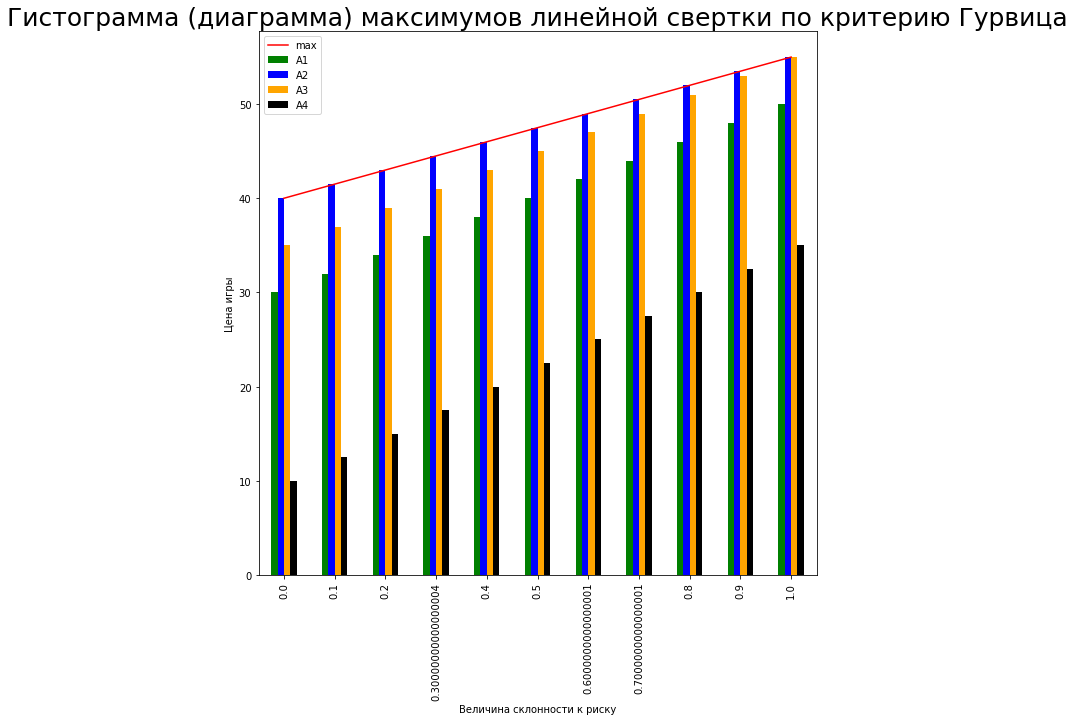

In [75]:
game = UndefinedGame(game_matrix_A, names_of_strategies_a, names_of_strategies_nature)
game.pessimizm()
game.optimizm()
game.Vald()
game.Savage()
game.Gurviz()
print(game)
game.show_Gurviz_diagramm()